# IBM Open Science Prize 2022 

**Group:** _Stefan Sack, Stefano Barison_

In [1]:
## TODO: little introduction?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1 - Classical simulation 

In [3]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [4]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

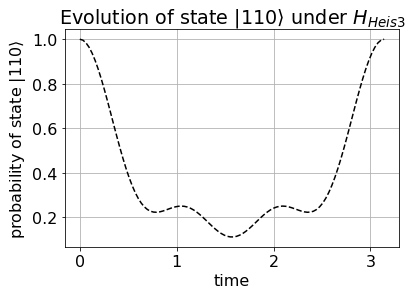

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

## 2- The Open Science Prize

The aim is to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$).

### 2.1 - Trotterization comparison

For this reason, we will start analysing how a Trotterization on a perfect quantum device will evolve the state $|110\rangle$ to time $t=\pi$ given a fixed number of Trotter steps.

In [6]:
## Import functions from Qiskit
from qiskit                  import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer    import QasmSimulator
from qiskit.tools.monitor    import job_monitor
from qiskit.circuit          import Parameter
from qiskit.quantum_info     import Statevector
from qiskit.opflow.state_fns import CircuitStateFn

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info                  import state_fidelity

In [7]:
## In the "trotter_function.py" file are contained all the functions useful for a perfect Trotter simulation
from trotter_functions import Heisenberg_Trotter_1st_ord, Heisenberg_Trotter_1st_ord_compressed

In [8]:
## Let's simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
t_steps = [4,8,12]
probs_110_trott = {4:[],8:[],12:[]}
t = Parameter("t")

for t_n in t_steps:
    for sim_t in ts:
        # Initialise the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_step = Heisenberg_Trotter_1st_ord(num_qubits=3,trotter_steps=t_n,p=t,target_time=sim_t).to_instruction()
        trott_qc.append(trott_step, [trott_qr[0], trott_qr[1], trott_qr[2]])
    
    
        trott_wfn = CircuitStateFn(trott_qc)
        trott_ovp = np.abs((~initial_state@trott_wfn).eval())**2
        probs_110_trott[t_n].append(trott_ovp)
    print(str(t_n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


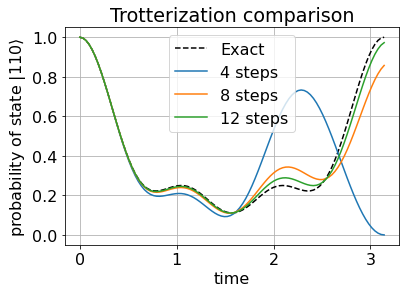

In [9]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i),label=str(t_n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, four Trotter steps are not enough to correctly time evolve the target state to $t=\pi$.
As expected, increasing the Trotter steps we get closer and closer to the exact simulation.

However, we are limited in the circuit depth that we can implement on hardware. For this reason, the aim of this notebook will be to compress the greatest Trotterization accuracy into the shortest possible circuit, before even applying error mitigation techniques.

### 2.2 Compress the Trotter step

The first step is to reduce the number of gates required by a single Trotter step. 
To this point, a single Trotter step requires $12$ CNOTs.

We can easily reduce it to $6$ using an optimal circuit for the $XX+YY+ZZ$ rotation presented in [Quantum computers as universal quantum simulators: state-of-art and perspectives](https://arxiv.org/abs/1907.03505).

In particular, we will consider the decomposition in Fig. 4b, while the initial Trotterization corresponds to the decomposition in Fig. 4a.

With this decomposition, 4 Trotter steps on 3 qubits will now require 24 CNOTs instead of 48.

To show that the two decompositions are equivalent, let us compare a single uncompressed & compressed Trotter step.

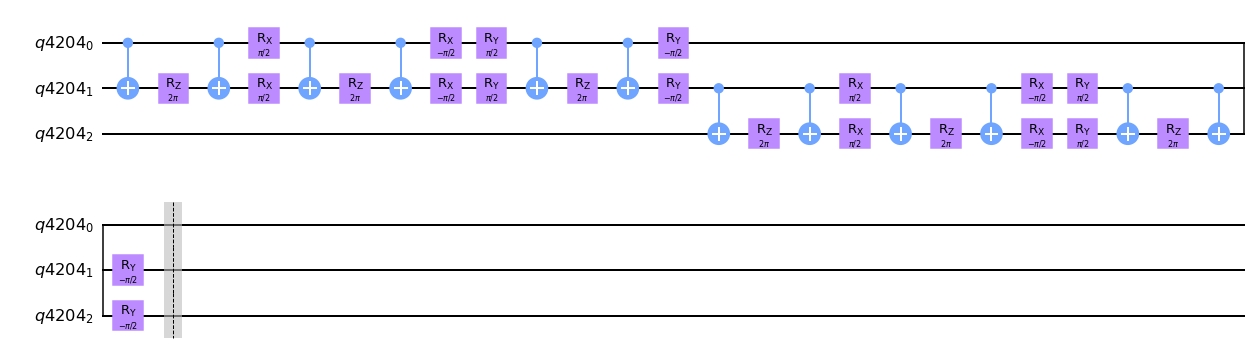

In [10]:
qc_1st_ord = Heisenberg_Trotter_1st_ord(3, 1, np.pi, np.pi)
qc_1st_ord.decompose().decompose().draw("mpl")

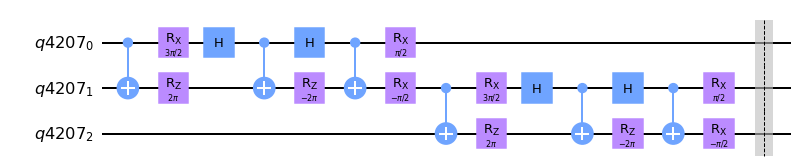

In [11]:
qc_1st_ord_compressed = Heisenberg_Trotter_1st_ord_compressed(3, 1, np.pi, np.pi)
qc_1st_ord_compressed.decompose().decompose().draw("mpl")

In [12]:
#TODO: maybe better to put arbitrary angles here

Using the qiskit Operator object we can check that they are exactly the same.
A detailed derivation of the equivalence can be found in the original paper, mentioned above.

In [13]:
from qiskit.quantum_info import Operator
Op_1st_order = Operator(qc_1st_ord)
Op_1st_order_compressed = Operator(qc_1st_ord_compressed)

print("The two circuits are the same: ", Op_1st_order.equiv(Op_1st_order_compressed))

The two circuits are the same:  True


Great, we will thus from now on use the compressed circuit!

### 2.3 Variational compression - the pVQD algorithm

In [14]:
## TODO: add the pVQD algorithm + explanation

# Some nice explanation for what it does and code that is self explanatory (routines such as SPSA can be stored in external file)
# pVQD should return vector of variational time steps that we can used in the further steps

In [15]:
## This part has to be similar to the "run_pVQD" function in the pVQD.py file

In [16]:
# I have given up on the pVQD, the code is too complicated for me. I have zero idea what is happening
# I hope we can make it more accessible 

### Please, please, please do no delete this part!!! 

### It is currently the only working way of obtaining optimal parameters

In [17]:
## Import the variational function 
# TODO: Use the same function for trotter and variational
from trotter_functions import Heisenberg_Trotter_1st_ord_compressed_variational

In [18]:
from qiskit.circuit import Parameter, ParameterVector
from qiskit.aqua.components.optimizers import COBYLA
from qiskit import Aer


In [19]:
θ = ParameterVector('θ', 4)

In [39]:
# This is the cost function to find the optimal parameters, this should be done via the pVQD instead!
def objective_function(params):

    backend = Aer.get_backend('statevector_simulator')

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc) 

    qc.append(Heisenberg_Trotter_1st_ord_compressed_variational(3, 4, θ), [qr[1], qr[3], qr[5]])
    qc = qc.bind_parameters({θ: params})

    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

In [40]:
# This will be replaced by the pVQD!!!

# Optimize the circuit parameters
optimizer = COBYLA(maxiter=50, tol=0.001)
params = (np.pi/4)*np.ones(4)
ret = optimizer.optimize(num_vars=4, objective_function=objective_function, initial_point=params)

In [41]:
ret[0]

array([2.43782622, 0.30323572, 0.68987612, 0.40946295])

In [24]:
# Define the final circuit that is used to compute the fidelity 
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)
qc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
qc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
qc.append(Heisenberg_Trotter_1st_ord_compressed_variational(3, 4, ret[0]), [qr[1], qr[3], qr[5]])

### 2.4 Final compression

In [340]:
## TODO: reduction to 15 CNOTs?

The circuit now has 24 CNOTs which is already very good, though it can be compressed even further! To this end we will be using the [Yang-Baxter Equation](https://www.worldscientific.com/doi/epdf/10.1142/S0217751X89001503) (YBE) which has recently been used by [Gulania et. al](https://arxiv.org/pdf/2112.01690.pdf) to compress the circuit for a Trotterized time evolution of the XY Heisenberg model. 

The YBE equation works in the following way:



In [54]:
# TODO: there is also a conjecture that we should cite.
# TODO: Import figure to illustrate the procedure, compute new variables variationally similar to the pVQD precedure (minimizing a local cost function).

In [55]:
# First try with fidelity estimation (please do not remove)

In [61]:
θ2 = ParameterVector('θ2', 5)

In [62]:
qc

In [63]:
# This is the cost function to find the optimal parameters, this should be done via the pVQD instead!
def objective_function(params):

    backend = Aer.get_backend('statevector_simulator')

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
    qc.append(Heisenberg_Trotter_1st_ord_compressed_variational(3, 4, ret[0]), [qr[1], qr[3], qr[5]])
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc) 

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
    qc.append(Heisenberg_Trotter_1st_ord_compressed_variational_YBE(3, θ2),  [qr[1], qr[3], qr[5]])
    qc = qc.bind_parameters({θ2: params})

    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

In [64]:
# Optimize the circuit parameters
optimizer = COBYLA(maxiter=50, tol=0.001)
params = (np.pi/4)*np.ones(5)
ret2 = optimizer.optimize(num_vars=5, objective_function=objective_function, initial_point=params)

In [65]:
ret2

(array([0.79418723, 1.30183221, 1.57003833, 1.8463565 , 0.81220337]),
 7.726481114789241e-05,
 50)

In [ ]:
##### Second try with VQE (please do not remove)

In [60]:
from trotter_functions import Heisenberg_Trotter_1st_ord_compressed_variational_YBE
from pVQD import projector_zero_local
from qiskit.utils import QuantumInstance

In [242]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)
qc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
qc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits

In [243]:
θ2 = ParameterVector('θ2', 5)

In [244]:

qc.append(Heisenberg_Trotter_1st_ord_compressed_variational(num_qubits, 4, ret[0]), [qr[1], qr[3], qr[5]]).inverse()
qc.append(Heisenberg_Trotter_1st_ord_compressed_variational_YBE(num_qubits, θ2), [qr[1], qr[3], qr[5]])


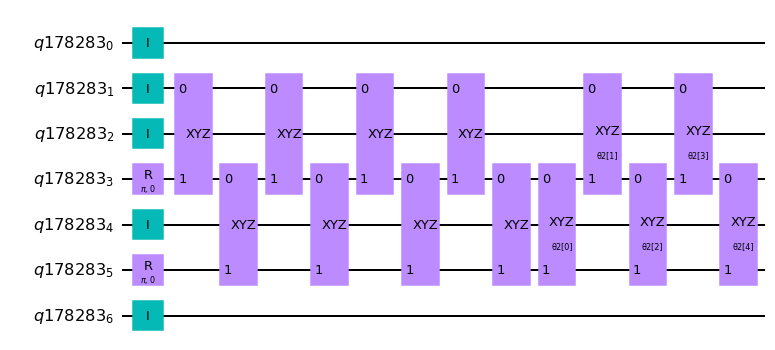

In [245]:
qc.decompose().draw("mpl")

In [246]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.opflow import I

In [247]:
tmp = I^I^I^I^I^I^I

In [249]:
seed = 50
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

# slsqp = SLSQP(maxiter=1000)
optimizer = COBYLA(maxiter=50, tol=0.001)

vqe = VQE(qc, optimizer=optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=tmp-projector_zero_local(7))
optimizer_evals = result.optimizer_evals

In [250]:
print(result)

OrderedDict([   ('aux_operator_eigenvalues', None),
                ('cost_function_evals', 40),
                (   'eigenstate',
                    array([-6.35543793e-16-1.86363871e-16j,  0.00000000e+00+0.00000000e+00j,
        9.72281893e-17-2.86932526e-16j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        4.00948622e-16+2.10711904e-16j,  0.00000000e+00+0.00000000e+00j,
        6.08594762e-01-6.48456718e-01j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.000

In [240]:
result.optimal_point

array([ 6.11172291, -2.89823478, -4.58773143, -3.19948246, -4.33438666])

## 3- Final Implementation

### 3.1 Error mitigation

Here we will use error mitigation to further improve the result. In particular we will be using Zero Noise Extrapolation (ZNE). For this the circuit depth is extended by unfolding gates, $G \rightarrow G G^\dagger G$. The circuit remains the same this way (since $G^\dagger G = I$), though the noise is increased. This way we can obtain results for different noise levels and extrapolate to the ideal, zero noise case. This prodecure is nicely wrapped into a single function provided by [mitiq](https://mitiq.readthedocs.io/en/stable/from). One simply has to be careful with minor bugs present in mitiq, we will comment on them below. 

In [42]:
from mitiq.zne.inference import PolyFactory
from mitiq.zne.zne import execute_with_zne

In [43]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-02-26 22:19:26,669: Credentials are already in use. The existing account in the session will be replaced.


In [44]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [45]:
# Setting all the parameters that are need
shots = 8192
backend = sim_noisy_jakarta

In [66]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)
qc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
qc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
qc.append(Heisenberg_Trotter_1st_ord_compressed_variational_YBE(3, ret2[0]),  [qr[1], qr[3], qr[5]])
#qc.append(Heisenberg_Trotter_1st_ord_compressed_variational(3, 4, ret[0]),  [qr[1], qr[3], qr[5]])


In [67]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

To use mitiq for noise mitigation we need to wrap the fidelity estimation via state tomography into a single "executor" function.

In [68]:
# Function that does state tomography and returns the fidelity
# To be used in the error mitigation (mitq)
def executor(circ):
    
    # Create list of state tomography circuits out of circ
    st_qcs = state_tomography_circuits(circ, [qr[1], qr[3], qr[5]])

    # Execute the state tomography circuits 
    job = execute(st_qcs, backend, optimization_level=3, shots=shots)
    print('Job ID', job.job_id())
    
    return state_tomo(job.result(), st_qcs)

In [69]:
# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0], order=2)

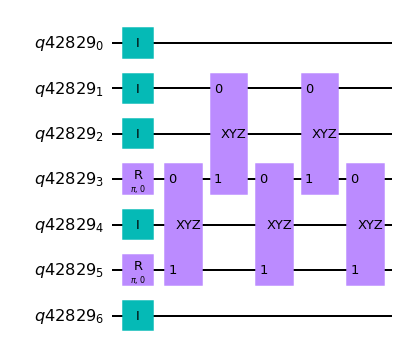

In [70]:
qc.decompose().draw("mpl")

In [71]:
# Repeat fidelity measurement
reps = 2 # Needs to be 8 in the final execution
fids = []
for _ in range(reps):
    
    # Circuit needs to be decomposed for mitq
    fids.append(execute_with_zne(qc.decompose().decompose(), executor, factory=poly_fac)) 

Job ID 39e693ba-56a4-4104-ac2f-59d93afb1e84
Job ID adaa102e-7550-4eff-9246-1f7516463479
Job ID be6f7a49-4b24-4a45-80b3-f64b7ac00fa8
Job ID e9c2dc0b-eda5-4b86-8271-da0157493f45
Job ID 32f12c2f-46f5-45c3-bccf-46e77df843e2
Job ID be4b8da0-2078-49a0-a164-e324212e088e


In [73]:
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.8044 ± 0.0081


In [ ]:
# Compression does wonders! :) 